In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, '..')

import random
from itertools import combinations

import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
import altair as alt

from paradeller.samples import load_samples
from paradeller.helper import (
    load_archive,
    save_to_pickle,
    read_from_pickle
)
from paradeller.dataprep import (
    tokenize,
    find_duplicates,
    filter_out_duplicates,
    filter_out_short,
    filter_out_oddballs,
    filter_out_oddballs_recursive,
    restructure_data,
    create_adj_list_by_word,
    create_adj_list_by_id
)
from paradeller.analysis import (
    find_matches,
    find_matches_for_start_pairs
)

In [2]:
def get_tweet(i):
    """Find tweet with given id"""
    try:
        return next(x for x in data if x["id"] == i)
    except StopIteration as e:
        print("Error: No tweet with that ID")
        return None

showlen = lambda data: print(f"Length: {len(data):,}")

## Get Data

In [3]:
#######################
USE_PICKLE = True
UPDATE_PICKLE = True
USE_SAMPLE = False
#######################


if USE_PICKLE:
    print("Loading real, processed data from pickle...")
    data, duplicates, adj_list_words, adj_list_ids = read_from_pickle()
else:
    if USE_SAMPLE:
        print("Loading unprocessed sample data...")
        data = load_samples()
    else:
        print("Loading unprocessed real data...")
        data = load_archive()
    
    showlen(data)
    print("\nCleaning up data...")

    # remove too short
    print("> Remove too short")
    data = filter_out_short(data)
    showlen(data)
    
    # remove duplicate phrases
    print("> Remove duplicate phrases")
    duplicates = find_duplicates(data)
    data = filter_out_duplicates(data, duplicates)
    showlen(data)

    # remove oddballs (too few matches)
    print("> Recursively remove oddballs")
    data = filter_out_oddballs_recursive(data)
    showlen(data)

    print("\nCreating adjacency lists...")
    # make adj lists
    adj_list_words, adj_list_ids = restructure_data(data)
    
    if UPDATE_PICKLE:
        print("\nSaving new data to pickle...")
        save_to_pickle((data, duplicates, adj_list_words, adj_list_ids))
        
    
print("-"*50)
print("DONE\n")
stuff = {
    "data": data, "duplicates": duplicates, "adj_list_words": adj_list_words, "adj_list_ids": adj_list_ids
}
for k, v in stuff.items():
    print(f"{k:15} type: {type(v)}\tlen: {len(v):,}")

Loading real, processed data from pickle...
--------------------------------------------------
DONE

data            type: <class 'list'>	len: 113,237
duplicates      type: <class 'dict'>	len: 161,579
adj_list_words  type: <class 'dict'>	len: 13,032
adj_list_ids    type: <class 'dict'>	len: 113,237


## Find Tweets

### Sort by popularity of words

In [4]:
from statistics import mean

In [5]:
# sort tweet ids by avg popularity of its words
pop = []
for tweet_id, words in tqdm(adj_list_ids.items()):
    pop.append((
        tweet_id,
        mean([len(adj_list_words[word]) for word in words])
    ))
    
pop.sort(key=lambda x: x[1], reverse=True)

In [6]:
df = pd.DataFrame(pop, columns=['id', 'pop'])

df['pop'].describe()

count    113237.000000
mean       3879.484035
std        2449.791870
min           3.000000
25%        2003.846154
50%        3489.750000
75%        5441.600000
max       15554.500000
Name: pop, dtype: float64

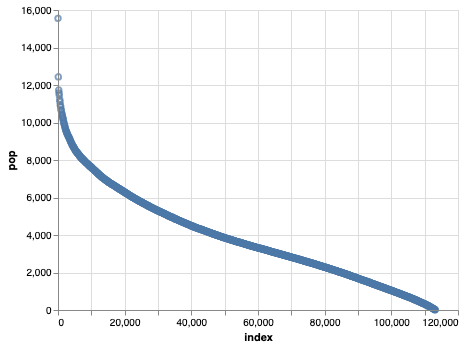

In [7]:
alt.Chart(df.reset_index()[::100]).mark_point().encode(
    x='index',
    y='pop',
)

## Run Search

In [8]:
some_ids = [x[0] for x in pop[:20]]
pairs = list(combinations(some_ids, 2))

print(f"{len(pairs):,}")

190


In [11]:
all_valid = find_matches_for_start_pairs(pairs, adj_list_ids, adj_list_words)

In [12]:
len(all_valid)

0

In [13]:
for pair, matches in all_valid.items():
    t1, t2 = pair
    stanza_start = [t1, t1, t2, t2]
    for match in matches:
        a, b = match
        stanza = stanza_start + [a, b]
        print("~"*50)
        for t in stanza:
            tweet = get_tweet(t)
            print(f"@{tweet['author']:20} {tweet['text']} ")

## More optimizations

### No common words in start pairs

In [14]:
# start pairs should have no common words

# def no_common_words(pair):    
#     s1 = set(adj_list_ids[pair[0]])
#     s2 = set(adj_list_ids[pair[1]])
#     return len(s1.intersection(s2)) == 0

# pairs = [p for p in pairs if no_common_words(p)]
# comma_print(len(pairs))

### Parallelization??

In [15]:
from math import sqrt
from joblib import Parallel, delayed

from multiprocessing import Pool
import os

In [16]:
some_ids = [x[0] for x in pop[:20]]
pairs = list(combinations(some_ids, 2))

print(f"{len(pairs):,}")

190


In [17]:
def find_matches_for_pair(p):
    return find_matches(p[0], p[1], adj_list_ids, adj_list_words)

In [18]:
with Pool(os.cpu_count()) as pool:
    res = list(tqdm(
        pool.imap(find_matches_for_pair, pairs),
        total=len(pairs)
    ))

In [19]:
res = [find_matches_for_pair(p) for p in tqdm(pairs)]

In [20]:
all_valid = [x for x in list(zip(pairs, res)) if x[1]]

In [21]:
for pair, matches in all_valid:
    t1, t2 = pair
    stanza_start = [t1, t1, t2, t2]
    for match in matches:
        a, b = match
        stanza = stanza_start + [a, b]
        print("~"*50)
        for t in stanza:
            tweet = get_tweet(t)
            print(f"@{tweet['author']:20} {tweet['text']} ")

In [43]:
%%timeit
res = [find_matches_for_pair(p) for p in pairs]

8.41 s ± 175 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
def find_matches_for_pair(p):
    return find_matches(p[0], p[1], adj_list_ids, adj_list_words)

In [11]:
# Parallel(n_jobs=4)(delayed(find_matches_for_pair)(p) for p in pairs)

In [13]:
def find_matches_for_pair(p):
    return find_matches(p[0], p[1], adj_list_ids, adj_list_words)

In [58]:
# with Pool(os.cpu_count()) as pool:
#     res = pool.map(find_matches_for_pair, pairs)

In [ ]:
with Manager() as manager:
    d1 = adj_list_ids
    d2 = adj_list_words
    
    p = Process(target=f, args=(d, l))
    p.start()
    p.join()

In [ ]:
all_valid = [x for x in list(zip(pairs, res)) if x[1]]

In [ ]:
for pair, matches in all_valid:
    t1, t2 = pair
    stanza_start = [t1, t1, t2, t2]
    for match in matches:
        a, b = match
        stanza = stanza_start + [a, b]
        print("~"*50)
        for t in stanza:
            tweet = get_tweet(t)
            print(f"@{tweet['author']:20} {tweet['text']} ")

### Arrays??

In [15]:
import scipy.sparse as sp
from scipy.sparse import dok_matrix

In [16]:
x = len(adj_list_ids.keys())
y = len(adj_list_words.keys())

In [17]:
ids = np.array(list(adj_list_ids.keys()))

In [18]:
words = np.array(list(adj_list_words.keys()))

In [19]:
S = dok_matrix((len(ids), len(words)), dtype=np.bool)

In [21]:
for i in tqdm(range(len(ids))):
    for j in range(len(words)):
        val = ids[i] in adj_list_words[words[j]]
        S[i, j] = val

### Timing

Timing

- Takes ~73 ms

In [51]:
# get some random pairs

ids = list(adj_list_ids.keys())
some_ids = [
    random.choice(ids)
    for _ in range(100)
]
pairs = list(combinations(some_ids, 2))
some_pairs = [random.choice(pairs) for _ in range(10)]

In [54]:
# run some tests

def timed(pair, d):
    a, b = pair
    res = %timeit -o find_matches(a, b, adj_list_ids, adj_list_words)
    d[pair] = (res.average * 1000)

d = {}
for p in tqdm(some_pairs):
    timed(p, d)

80.1 ms ± 9.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
250 ms ± 123 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
263 ms ± 51.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
315 ms ± 52.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
403 ms ± 94.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
435 ms ± 58.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
385 ms ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
351 ms ± 59.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
317 ms ± 83.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
191 ms ± 30.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
df = pd.DataFrame(list(d.items()), columns=['pair', 'ms'])
df

,pair,ms
0,"(1146105413105881088, 1146116898079330304)",80.115029
1,"(1144673540777623552, 1145885481265258499)",249.871943
2,"(1145553510827606017, 1146211738850865153)",263.152325
3,"(1144662246301294592, 1145874065036599296)",315.272664
4,"(1144390429326004224, 1145840012421935104)",402.755159
5,"(1144386432347152384, 1146468228589346816)",434.943555
6,"(1144662246301294592, 1145885492920983552)",385.155483
7,"(1146253446963707905, 1146215547543203840)",351.251270
8,"(1146514656581881856, 1145916035557658625)",317.222082
9,"(1146101727239663616, 1145839984550842369)",190.772397


In [56]:
df.describe()

,ms
count,10.000000
mean,299.051191
std,107.143740
min,80.115029
25%,253.192039
50%,316.247373
75%,376.679430
max,434.943555


In [61]:
avg_run_ms = df.describe().loc['mean', 'ms']
avg_run_ms

299.05119075860574

In [60]:
# see how long it takes to check increasing numbers of ids
res = []
for num_ids in tqdm([10, 100, 200, 500, 1000, 2000, 5000, 10_000]):
    some_ids = [
        random.choice(ids)
        for _ in range(num_ids)
    ]
    pairs = list(combinations(some_ids, 2))
    total_ms = len(pairs) * avg_run_ms
    seconds = total_ms / 1000
    
    res.append((num_ids, len(pairs), seconds))

In [62]:
df = pd.DataFrame(res, columns=['ids', 'pairs', 'seconds'])
df['hours'] = df['seconds'] / 60 / 60
df

,ids,pairs,seconds,hours
0,10,45,1.345730e+01,0.003738
1,100,4950,1.480303e+03,0.411195
2,200,19900,5.951119e+03,1.653089
3,500,124750,3.730664e+04,10.362954
4,1000,499500,1.493761e+05,41.493353
5,2000,1999000,5.978033e+05,166.056481
6,5000,12497500,3.737392e+06,1038.164516
7,10000,49995000,1.495106e+07,4153.073412


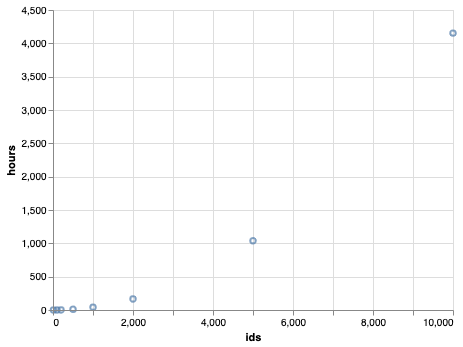

In [64]:
alt.Chart(df).mark_point().encode(
    x='ids',
    y='hours'
)